In [9]:
import pandas as pd
import numpy as np
from datetime import datetime


In [11]:
# CSV 파일을 읽어들입니다.
df = pd.read_csv("집단사례보고.csv")

# '집단발병일' 컬럼을 datetime으로 변환하면서 형식에 맞지 않는 날짜는 NaT으로 설정합니다.
df['집단발병일'] = pd.to_datetime(df['집단발병일'], format='%Y%m%d', errors='coerce')

# 형식에 맞지 않아 NaT으로 설정된 데이터를 제외합니다.
df = df.dropna(subset=['집단발병일'])

# 날짜 범위를 지정합니다.
start_date = pd.to_datetime('20210814', format='%Y%m%d')
end_date = pd.to_datetime('20211013', format='%Y%m%d')

# 날짜 범위에 속하는 행만 필터링합니다.
df = df[(df['집단발병일'] >= start_date) & (df['집단발병일'] <= end_date)]
df

,클러스터,시리얼,확진자번호,집단발병일,장소,상호,주소,신고지,성별,연령,...,방역수칙_행정명령,방역수칙_sum,위험도_1,위험도_2,위험도_3,위험도_4(군집도),위험도_5,위험도_6,sum,기타
2300,214,2303,NaN,2021-08-14,교회,포도나무교회,용인시기흥구,용인시,2,.,...,0,3,1,1,2,.,1,2,7,NaN
2301,214,2304,NaN,2021-08-15,교회,포도나무교회,용인시기흥구,용인시,2,.,...,0,3,1,1,2,.,1,2,7,NaN
2302,214,2305,NaN,2021-08-16,교회,포도나무교회,용인시기흥구,용인시,1,.,...,0,3,1,1,2,.,1,2,7,NaN
2303,214,2306,NaN,2021-08-17,교회,포도나무교회,용인시기흥구,용인시,2,.,...,0,3,1,1,2,.,1,2,7,NaN
2304,214,2307,NaN,2021-08-18,교회,포도나무교회,용인시기흥구,용인시,1,.,...,0,3,1,1,2,.,1,2,7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4977,393,4980,안산#6422,2021-10-13,학원,벨스영수학원,안산시,안산시,2,8,...,.,0,2,2,2,.,1,2,9,NaN
4978,393,4981,안산#6426,2021-10-13,학원,벨스영수학원,안산시,안산시,2,13,...,.,0,2,2,2,.,1,2,9,NaN
4979,393,4982,안산#6427,2021-10-13,학원,벨스영수학원,안산시,안산시,2,12,...,.,0,2,2,2,.,1,2,9,NaN
4980,393,4983,안산#6437,2021-10-13,학원,벨스영수학원,안산시,안산시,1,12,...,.,0,2,2,2,.,1,2,9,NaN


## 데이터 전처리

#### 사용 Data : 규칙

Primary case : 2->1, Nan->0

장소 : 장소 index로 변경

주소 : 주소 index로 변경

신고지 : 신고지 index로 변경

직업 : 직업 index로 변경

성별 : 내/외국인 분리하여 is_korean feature 사용
       남자 1, 여자 0

집단발병일, 확진일 : 차이를 계산하여 diff_days column으로 사용

방역 수칙 sum : Nan -> 같은 클러스터 값으로 대치 

위험도 sum : Nan -> 같은 클러스터 값으로 대치

CT_R : Nan -> 전체 평균

CT_E : Nan -> 전체 평균

연령 : 장소 index 별 연령 평균으로 결측값 대치



In [12]:
# df = pd.read_csv("집단사례보고.csv" )
cluster_df = df["장소"]
my_list = [s for s in cluster_df.unique() if not s.endswith(')')]

### 장소 mapping

In [13]:
mapping={'병원':12,
 '요양시설':11,
 '어린이집':18,
 '초등학교':9,
 '직장':7,
 '병원콜센터':6,
 '요양병원':12,
 '장애인거주시설':11,
 '물류센터':3,
 '자동차전시장':4,
 '사우나':8,
 '태권도장':14,
 '헬스장':14,
 '시청':8,
 '교회':13,
 '컨설팅업':7,
 '음료제조업':19,
 '다이어트장':14,
 '동호회':17,
 '대학교':9,
 '음식점':15,
 '학원':10,
 '학교':9,
 '광고물제조업':1,
 '세무사사무소':6,
 '당구장':14,
 '화장품제조업':1,
 '자동차연구소':6,
 '콜센터':6,
 '골판지제조업':5,
 '실내운동시설':14,
 '공장':1,
 '제조업':1,
 '불교':13,
 '단란주점':16,
 '연구기관':6,
 '자영업':15,
 '가구점':4,
 '이슬람사원':13,
 '농산물유통센터':4,
 '농산물제조판매업':19,
 '건설현장':2,
 '보험사':6,
 '축산업':19,
 '유흥주점':16,
 '장례식장':8,
 '건설회사':2,
 '생산공장':1,
 '농수산물류센터':4,
 '계란공장':19,
 '의료기매장':6,
 '지인모임':17,
 '유치원':18,
 '건축사무소':6,
 '학교급식실':9,
 '성당':13,
 '체대입시학원':14,
 '댄스학원':14,
 '어학원':10,
 '탁구장':14,
 '기숙학원':8,
 '고등학교':9,
 '특수학교':9,
 '보험회사':7,
 '반도체제조업':1,
 '보도방':16,
 '외국인숙소':8,
 '피아노학원':10,
 '보드게임장':17,
 '중학교':9,
 '의류공장':1,
 '보습학원':10,
 '음악학원':10,
 'KT본사':7,
 '제조업체생산라인':1,
 '신발제작공장':1,
 '제조업체':1,
 '화물운송협회':3,
 '자동차부품생산업체':1,
 '제조업공장':1,
 '자동차공장':1,
 '직업기술학원':10,
 '가공식품도매업':4,
 '제조업공장사내기숙사':8,
 '주점':16,
 '식료품제조업체':19,
 '무속신앙':13,
 '통신전선설치업체':6,
 '개인과외':17,
 '교육원':8,
 '사내기숙사':8,
 '노래방':16,
 '전자회사':7,
 '주짓수':14,
 '무에타이':14,
 '고시원':8,
 '식품제조업체':19,
 '도금업체':1,
 '가전제조판매업체':4,
 '산업체':1,
 '시멘트제조업체':1,
 '아이스링크장':14,
 '아파트건설현장':2,
 '고시텔':8,
 '대안학교':9,
 '자동차부품도장업체':6,
 '파이프가공공장':1,
 '주간보호센터':11,
 '공공기관':8,
 '육류가공업체':14,
 '렌탈업체':6,
 '대학교기숙사':8,
 'IT업':7,
 '플라스틱제조업':1,
 '사진스튜디오':6,
 '가구제조업':1,
 '전자부품제조업':1,
 '기계제조업':1,
 '자동차부품제조업':1,
 '장애인복지시설':11,
 '박스제조업':1,
 '장비제조업':1,
 '장비제조업(지인':1,
 '외국인근로자기숙사':8,
 '도장및피막처리업':1,
 '전자전기제품제조업':1,
 '인력사무소':6,
 '반도체장비부품가공업':1,
 '염료제조업':1,
 '건축제조업':1,
 '중공업':2,
 '알루미늄주조업':1,
 '축산물가공업':4,
 '모델하우스':6,
 '사료제조업':19,
 '인쇄업체':6,
 '영어학원':10,
 '마스크제조업':1,
 '콘크리트제조업':1,
 '금속처리업':1,
 '자동차정비업':6,
 '재활용품분류센터':5,
 '육류가공제조업':19,
 '농구단':14,
 '금속가공제품제조업':1,
 '냉장창고업':19,
 '여과기제조업':1,
 '식품제조업':19,
 '금형제조업':1,
 '코인노래방':16,
 '게임회사':7,
 '재활용업체':5,
 '원단제조업':1,
 '철강제조업':1,
 '고속도로사업소':6,
 '대학교체육부':14,
 '광학부품전문제조업':1,
 '건설업':2,
 '섬유가공업':1,
 '택배물류센터':4,
 '플라스틱용기제조업':1,
 '대형마트':4,
 '요양원':11,
 '골판지상자제조업':1,
 '식품가공업':19,
 '분양상담소':6,
 '농공시설업':1,
 '포장용상자제조업':1,
 'PC방':16,
 '염색가공업':4,
 '학교축구부':14,
 '대형마트물류센터':4,
 '섬유제조업':1,
 '양돈업':19,
 '전자상거래소매업':6,
 '종이제조업':1,
 '플라스틱재활용페기업체':5,
 '피혁가공판매업':5,
 '택배영업소':4,
 '간판제조업':1,
 '자동차판매업':4,
 '무역업':4,
 '피혁원단제조업':1,
 '대부중개업':6,
 '인쇄업':6,
 '태권도학원':10,
 '전자제품제조업':1,
 '의류선별및수출업':4,
 '창호제조업':1,
 '낙농제품제조업':19,
 '종교시설':13,
 '회사기숙사':8,
 '제조공장':1,
 '교욱원':10,
 '렌탈업쳬':6,
 '플라스틱재활용폐기업체':5
 }

In [14]:
def remove_bracket(s):
    """
    문자열에서 괄호안의 문자를 제거하는 함수
    """
    idx = s.find('(') # 괄호 시작 위치 찾기
    if idx != -1:
        s = s[:idx] # 괄호 이전 문자열만 남기기
    return s

def replace_column(df, column_name):
    """
    데이터프레임의 특정 컬럼에서 괄호안의 문자를 제거하고, 괄호 밖의 문자만 남긴 새로운 컬럼을 생성하는 함수
    """
    new_column_name = column_name + '_index'
    df[new_column_name] = df[column_name].apply(remove_bracket)
    df[new_column_name] = df[new_column_name].str.replace('(', '').str.replace(')', '') # 괄호 제거
    return df

In [15]:
df = replace_column(df, '장소')
df["장소"] = df["장소_index"].map(mapping)
df["장소클러스터"]=df["장소"]
df["장소"]=df["장소_index"]
df.drop("장소_index", axis=1, inplace=True)


In [16]:
def clean_value(value):
    if value =='강원시영월군':
        value = '영월군'
    if '시' in value and value != '시흥시':
        value = value.split('시')[0] + '시'
    if '연천' in value:
        value = '연천시'
    if '경기도' in value:
        value = value.replace('경기도 ', '')
    if '경기도' in value:
        value = value.replace('경기도', '')
    if '고양ㅅ' in value  or value == "덕양구" or value =='고양일산서구' or value =='고양덕양':
        value = '고양시'
    if '성남수분당구' in value:
        value = value.replace('성남수분당구', '성남시')
    if '안사시' in value:
        value = value.replace('안사시', '안산시')
    if value == '성북구'or value ==  '금천구'or value ==  '동대문구'or value ==  '구로구'or value ==  '동작구' or value ==  '영등포구' or value =="관악구" or value =="도봉구" or value =="용산구":
        value = '서울시'
    if value == "계양구" or value == '인천부평':
        value="인천시"
    if value == "의정뷧":
        value="의정부시"
    if value == "동두천":
        value="동두천시"
    if value == "양평":
        value="양평군"
    if value == "충북진천":
        value="진천군"
    if value == "충남부여":
        value="부여군"
    if value == "강원도철원군":
        value="철원군"
    if value == "경남고성군":
        value="고성군"
    if value == "충남당진":
        value="당진시"
    if value == "전북전주":
        value="전주시"
    if value == "충남태안":
        value="태안군"
    if value == "충북충주":
        value="충주시"
    if value == "강원춘천":
        value="춘천시"
    if value == "포천":
        value="포천시"
    if value == "경북고창":
        value="고창군"
    return value

In [17]:
df['주소'] = df['주소'].apply(clean_value)

df["주소"].unique()

array(['용인시', '성남시', '화성시', '안산시', '김포시', '수원시', '평택시', '시흥시', '연천시',
       '안성시', '오산시', '파주시', '광명시', '양주시', '가평군', '고양시', '남양주시', '이천시',
       '구리시', '의정부시', '여주시', '포천시', '부천시', '광주시', '동두천시', '안양시', '군포시'],
      dtype=object)

In [18]:
add_map={'광주시':0, '부천시':1, '안양시':2, '용인시':3, '파주시':4, '고양시':5, '평택시':6, '의정부시':7, '양평시':8,
       '성남시':9, '화성시':10, '남양주시':11, '하남시':12, '수원시':13, '안산시':14, '과천시':15, '구리시':16, '포천시':17,
       '광명시':18, '김포시':19, '오산시':20, '군포시':21, '안성시':22, '여주시':23, '시흥시':24, '의왕시':25, '이천시':26,
       '가평군':27, '동두천시':28, '연천군':29, '양주시':30}

In [19]:
df['주소_index']=df['주소'].map(add_map)

### 신고지 mapping

경기도를 제외한 지역의 세분화는 최소화 하였음

In [20]:
def clean_value_rep(value):
    if value =='강원시영월군':
        value = '영월군'
    if '시' in value and value != '시흥시':
        value = value.split('시')[0] + '시'
    if '연천시' in value:
        value = '연천군'
    if '경기도' in value:
        value = value.replace('경기도 ', '')
    if '경기도' in value:
        value = value.replace('경기도', '')
    if '고양ㅅ' in value  or value == "덕양구" or value =='고양일산서구' or value =='고양덕양':
        value = '고양시'
    if '성남수분당구' in value:
        value = value.replace('성남수분당구', '성남시')
    if value == '구로시'or value == '송파구'or value == '노원시':
        value = "서울시"
    if value =="부평시":
        value = '인천시'
    if value =="일산시":
        value = '고양시'
    if value == "대구시" or value == "천안시" or value == '충북시'or value == '전주시'or value == '춘천시'or value == '태안군'or value == '포항시'or value == '전남시'or value == '괴산시'or value == '울산시'or value == '.'or value == '충주시'or value == '청주시'or value == '충남시'or value == '전북고창'or value == '영월군'or value == '어루시'or value == '김천시'or value == '당진시'or value == '부산시'or value == '원주시'or value == '진천군'or value == '부여군'or value == '대전시'or value == '세종시'or value == '철원군'or value == '고성군':
        value="전국"
    return value

In [21]:
df['신고지']=df['신고지'].apply(clean_value_rep)
df['신고지'].unique()

array(['용인시', '서울시', '성남시', '수원시', '화성시', '안산시', '시흥시', '광주시', '평택시',
       '김포시', '전국', '오산시', '안양시', '포천시', '인천시', '부천시', '연천군', '동두천시',
       '군포시', '파주시', '의정부시', '남양주시', '고양시', '의왕시', '구리시', '광명시', '양주시',
       '가평군', '안성시', '이천시', '양평', '하남시', '여주시', '관악구', '용산구', '구로구',
       '영등포구', '안사시', '과천시', '충남당진', '충북충주', '충북진천', '충남부여', '강원춘천'],
      dtype=object)

In [22]:
rep_map={'광주시':0, '부천시':1, '안양시':2, '용인시':3, '파주시':4, '고양시':5, '평택시':6, '의정부시':7, '양평시':8,
       '성남시':9, '화성시':10, '남양주시':11, '하남시':12, '수원시':13, '안산시':14, '과천시':15, '구리시':16, '포천시':17,
       '광명시':18, '김포시':19, '오산시':20, '군포시':21, '안성시':22, '여주시':23, '시흥시':24, '의왕시':25, '이천시':26,
       '가평군':27, '동두천시':28, '연천군':29, '양주시':30, '양평군':8, '인천시':31, "서울시":32, "전국":33}

In [23]:
df['신고지_index']=df['신고지'].map(rep_map)

In [24]:
df.drop(['증상발현일','시리얼','확진자번호','장소','상호','주소','신고지','직업명','CT_N','감염경로종합평가','개인위험특성','감염장소위험특성','백신접종사항','주요감염원인','클러스터외확진자','type_f','infector_id','primary_case_id','접촉자','Secon_attack','SA_F_Incld','방역수칙_1','방역수칙_2','방역수칙_3','방역수칙_4','방역수칙_5','방역수칙_행정명령','위험도_1','위험도_2','위험도_3','위험도_4(군집도)','위험도_5','위험도_6','기타'],inplace=True,axis=1)
df

,클러스터,집단발병일,성별,연령,직업대분류,확진일,CT_R,CT_E,primary case,확진자,방역수칙_sum,sum,장소클러스터,주소_index,신고지_index
2300,214,2021-08-14,2,.,99,20210807,.,.,0,14,3,7,13,3.0,3.0
2301,214,2021-08-15,2,.,99,20210807,.,.,0,14,3,7,13,3.0,3.0
2302,214,2021-08-16,1,.,99,20210807,.,.,0,14,3,7,13,3.0,3.0
2303,214,2021-08-17,2,.,99,20210807,.,.,0,14,3,7,13,3.0,3.0
2304,214,2021-08-18,1,.,99,20210808,.,.,0,14,3,7,13,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4977,393,2021-10-13,2,8,0,20211012,21.64,20.66,0,17,0,9,10,14.0,14.0
4978,393,2021-10-13,2,13,0,20211012,19.56,17.5,0,17,0,9,10,14.0,14.0
4979,393,2021-10-13,2,12,0,20211012,15.96,13.15,0,17,0,9,10,14.0,14.0
4980,393,2021-10-13,1,12,0,20211012,15.3,16.9,0,17,0,9,10,14.0,14.0


### 기타 항목 전처리


In [47]:
# 성별 1, 2 한국 남자, 한국 여자와 3, 4 외국남자 외국여자를 is_koren과 성별 두개의 coulumn으로 분리

df.loc[(df['성별'].isin(['1', '2'])), 'is_korean'] = '1'
df.loc[(df['성별'].isin(['3', '4'])), 'is_korean'] = '0'
df.loc[(df['성별'] == '3'), '성별'] = '1'
df.loc[(df['성별'] == '4'), '성별'] = '2'
df.loc[(df['성별'] == '2'), '성별'] = '0'

In [48]:
# primary case는 1로 통일

df['primary case'].replace('2', '1', inplace=True)

In [27]:
# 결측치 대체
df['CT_R'].replace('.', np.nan, inplace=True)
df['CT_R'] = df['CT_R'].astype(float)
df['CT_R'].fillna(df['CT_R'].mean(), inplace=True)

df['CT_E'].replace('.', np.nan, inplace=True)
df['CT_E'] = df['CT_E'].astype(float)
df['CT_E'].fillna(df['CT_E'].mean(), inplace=True)

# 각각의 평균값으로 결측치 사용
df["CT_R"] = df["CT_R"].fillna(df["CT_R"].mean())
df["CT_E"] = df["CT_E"].fillna(df["CT_E"].mean())

In [29]:
# 장소에 해당하는 연령의 평균으로 결측치 사용
df['연령'].replace('.', np.nan, inplace=True)
plc_idx=[]
for i in range(1, 20):
    x = df[df["장소클러스터"] == i]
    try:
        cluster_mean = x["연령"].astype("float").mean(skipna=True).round().astype("int32")
    except:
        cluster_mean = None
    plc_idx.append(cluster_mean)
    if cluster_mean is not None:
        print(i, cluster_mean)
    else:
        print(i, "No data")

for i in range(1, 20):
    cluster_mean = plc_idx[i-1]
    # plc_idx 리스트에 None 값이 있을 경우를 확인하고 처리합니다.
    if cluster_mean is not None:
        df.loc[df['장소클러스터'] == i, '연령'] = df.loc[df['장소클러스터'] == i, '연령'].fillna(cluster_mean)


1 38
2 42
3 37
4 41
5 42
6 38
7 44
8 38
9 22
10 14
11 71
12 70
13 41
14 28
15 40
16 26
17 No data
18 20
19 44


### 집단 발병일 과 확진일의 차이를 구해 diff_days로 계산, 클러스터의 지속 기간으로 간주하였음.

다만, 형식이 올바르지 못한 부분에 대해서는 수작업으로 이를 처리하여주었음

cluster 8 : 오류데이터? 제거 필요 

cluster 9, 80, 255 : 집단발병일 날짜 형식 어김. 확진일과 비교 임의로 수정.

cluster 105 확진자번호 946 : 확진 날짜 오타 추정 2010611 → 20210611

cluster 112 확진자번호 997 : 확진 날짜 오타 추정 2010614→20210614 

cluster 139 확진자번호 1408 : 확진 날짜 오타 추정 20210708→202210708

cluster 141 확진자번호 1422 : 확진 날짜 오타 추정 20211214→20201214

cluster 171 : 오류데이터? 제거 필요

cluster 220 확진자번호 2397 : 확진 날짜 오타 추정 20210617→20210817 (primary보다 이후에 감염되어야 하므로)

cluster 229 확진자번호 2514 : 확진 날짜 오타 추정 20210406→20210106

cluster 270 확진자번호 3129 : 확진 날짜 오타 추정 20201823→20210823

cluster 272 확진자번호 3153 : 확진 날짜 오타 추정 20201824→20210824

cluster 358 확진자번호 4638 : 확진 날짜 오타 추정 2210930→20210930

cluster 359 확진자번호 4394 : 확진 날짜 오타 추정 20011001→20211001  

cluster 373 확진자번호 4619 : 확진 날짜 오타 추정 2021005→20211005

cluster 375 확진자번호 4652 : 확진 날짜 오타 추정 20011005→20211005

cluster 378 확진자번호 4686 : 확진 날짜 오타 추정 2021006→20211006 

cluster 388 확진자번호 4877 : 확진 날짜 오타 추정 2021009→20211009 

cluster 431 확진자번호 5561 : 확진 날짜 오타 추정 20221028 → 20211028

cluster 445 확진자번호 5852 : 확진 날짜 오타 추정 2211030 → 20211030


In [30]:
for idx, row in df.iterrows():
    try:
        df.loc[idx, '집단발병일'] = pd.to_datetime(row['집단발병일'], format='%Y%m%d')
    except ValueError:
        print(f"올바르지 않은 형식의 날짜입니다: {row['집단발병일']}, {idx+1}번째 행")

    try:
        df.loc[idx, '확진일'] = pd.to_datetime(row['확진일'], format='%Y%m%d')
    except ValueError:
        print(f"올바르지 않은 형식의 날짜입니다: {row['확진일']}, {idx+1}번째 행")

# 날짜 차이 계산
# df['diff_days'] = (df['확진일'] - df['집단발병일']).dt.days

/tmp/ipykernel_1973975/436786340.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2021-08-07 00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, '확진일'] = pd.to_datetime(row['확진일'], format='%Y%m%d')


In [49]:
df.to_csv("2month_data_final_mod.csv", encoding='utf-8-sig', index=False)
df

,클러스터,집단발병일,성별,연령,직업대분류,확진일,CT_R,CT_E,primary case,확진자,방역수칙_sum,sum,장소클러스터,주소_index,신고지_index,is_korean
2300,214,2021-08-14,0,41,99,2021-08-07 00:00:00,27.833833,27.961922,0,14,3,7,13,3.0,3.0,1
2301,214,2021-08-15,0,41,99,2021-08-07 00:00:00,27.833833,27.961922,0,14,3,7,13,3.0,3.0,1
2302,214,2021-08-16,1,41,99,2021-08-07 00:00:00,27.833833,27.961922,0,14,3,7,13,3.0,3.0,1
2303,214,2021-08-17,0,41,99,2021-08-07 00:00:00,27.833833,27.961922,0,14,3,7,13,3.0,3.0,1
2304,214,2021-08-18,1,41,99,2021-08-08 00:00:00,27.833833,27.961922,0,14,3,7,13,3.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4977,393,2021-10-13,0,8,0,2021-10-12 00:00:00,21.640000,20.660000,0,17,0,9,10,14.0,14.0,1
4978,393,2021-10-13,0,13,0,2021-10-12 00:00:00,19.560000,17.500000,0,17,0,9,10,14.0,14.0,1
4979,393,2021-10-13,0,12,0,2021-10-12 00:00:00,15.960000,13.150000,0,17,0,9,10,14.0,14.0,1
4980,393,2021-10-13,1,12,0,2021-10-12 00:00:00,15.300000,16.900000,0,17,0,9,10,14.0,14.0,1


### df -> data_final_mod 

클러스터 : cluster

성별 : gender

is_korean : is_korean

primary case : primary case

연령 : age

CT_R : CT_R

CT_E : CT_E

방역수칙_sum : dis

sum : danger

직업대분류 : job_idx

장소클러스터 : place_idx

주소_index : add_idx

신고지_index : rep_idx

집단발병일을 통해 처리 : diff_days

집단발병일을 통해 처리 : y

In [55]:
df = df.rename(columns={
    '클러스터': 'cluster',
    '성별': 'gender',
    'is_korean': 'is_korean',
    'primary case': 'primary case',
    '연령': 'age',
    'CT_R': 'CT_R',
    'CT_E': 'CT_E',
    '방역수칙_sum': 'dis',
    'sum': 'danger',
    '직업대분류': 'job_idx',
    '장소클러스터': 'place_idx',
    '주소_index': 'add_idx',
    '신고지_index': 'rep_idx'
})
df['diff_days'] = (pd.to_datetime(df['집단발병일']) - pd.to_datetime(df['확진일'])).dt.days
df['dis'].value_counts()

dis
3    504
2    490
4    375
1    290
0    231
.    227
5    105
6     30
Name: count, dtype: int64

In [64]:

from pgmpy.estimators import PC
data = pd.read_csv('/data1/bubble3jh/Med/data/data_final_mod.csv')
# Initialize the PC algorithm estimator
est = PC(data)

# Estimate the causal structure using Chi-square test
model = est.estimate(ci_test='chi_square')

# Check if there is an edge between 'y' and 'dis' in the graph
edges = model.edges()
print(('y', 'dis') in edges or ('dis', 'y') in edges)

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting
Working for n conditional variables: 5: 100%|██████████| 5/5 [2:08:59<00:00, 1547.99s/it]


True


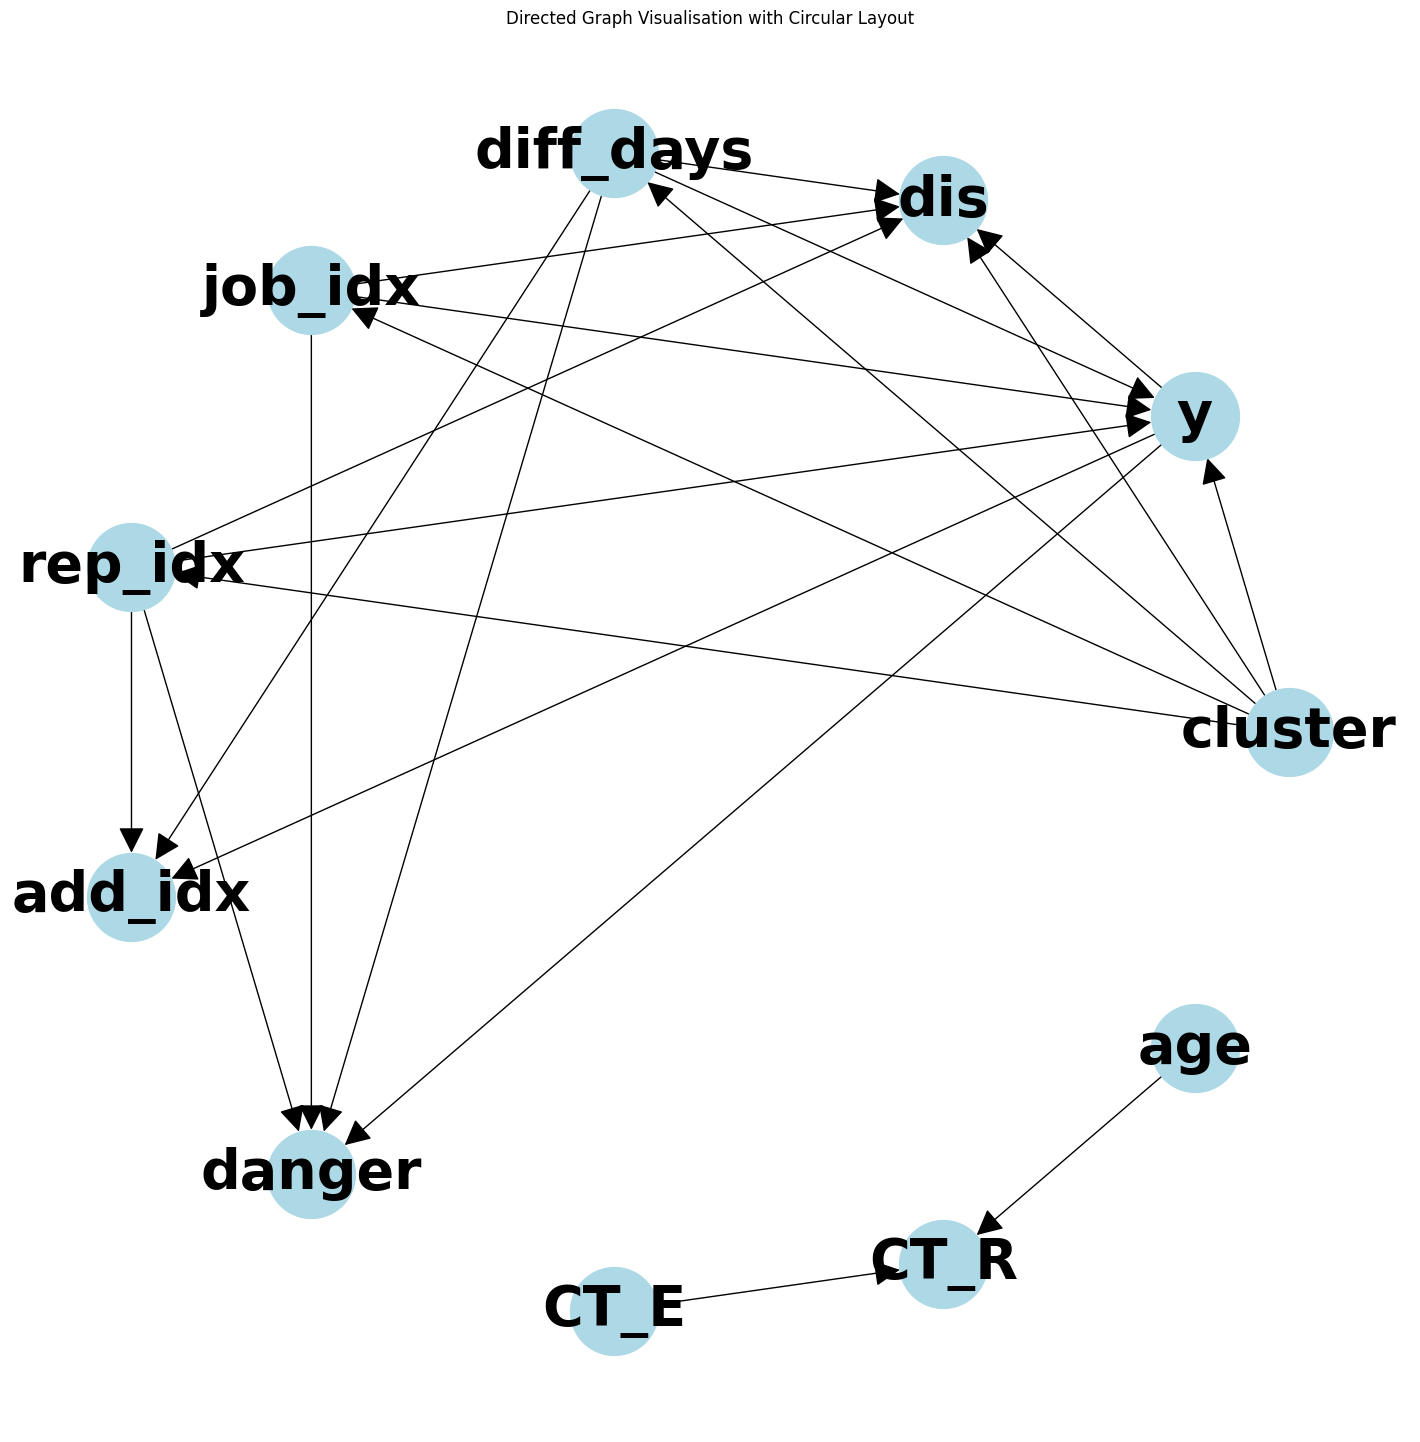

In [72]:
import networkx as nx
import matplotlib.pyplot as plt

# List of edges, each tuple represents a directed edge: (source, target)
edges = [('cluster', 'y'), ('cluster', 'dis'), ('cluster', 'diff_days'), 
         ('cluster', 'job_idx'), ('cluster', 'rep_idx'), ('y', 'add_idx'), 
         ('y', 'danger'), ('y', 'dis'), ('rep_idx', 'y'), ('rep_idx', 'add_idx'), 
         ('rep_idx', 'dis'), ('rep_idx', 'danger'), ('diff_days', 'add_idx'), 
         ('diff_days', 'dis'), ('diff_days', 'danger'), ('diff_days', 'y'), 
         ('job_idx', 'y'), ('job_idx', 'dis'), ('job_idx', 'danger'), 
         ('CT_E', 'CT_R'), ('age', 'CT_R')]

# Create a directed graph from the edges
# Create a directed graph from the edges
G = nx.DiGraph(edges)

# Draw the graph with a circular layout to avoid overlapping nodes
plt.figure(figsize=(14, 14))
pos = nx.circular_layout(G)  # positions for all nodes in a circular layout
nx.draw(G, pos, with_labels=True, node_size=4000, node_color='lightblue', 
        font_size=40, font_weight='bold', arrowstyle='-|>', arrowsize=40)
plt.title('Directed Graph Visualisation with Circular Layout')
plt.show()



In [65]:
model.edges()

OutEdgeView([('cluster', 'y'), ('cluster', 'dis'), ('cluster', 'diff_days'), ('cluster', 'job_idx'), ('cluster', 'rep_idx'), ('y', 'add_idx'), ('y', 'danger'), ('y', 'dis'), ('rep_idx', 'y'), ('rep_idx', 'add_idx'), ('rep_idx', 'dis'), ('rep_idx', 'danger'), ('diff_days', 'add_idx'), ('diff_days', 'dis'), ('diff_days', 'danger'), ('diff_days', 'y'), ('job_idx', 'y'), ('job_idx', 'dis'), ('job_idx', 'danger'), ('CT_E', 'CT_R'), ('age', 'CT_R')])

### 위 같은 절차를 거쳐 1차적인 전처리를 통해 ```data_final_mod.csv``` 생성

### cutoff date 별로 전처리 및 각각 csv 파일 생성

In [46]:
data = pd.read_csv("2month_data_final_mod.csv",encoding='utf-8-sig' )
data=data[['cluster', 'age', 'CT_R', 'CT_E', 'dis', 'danger','gender', 'is_korean', 'primary case', 
                   'job_idx', 'rep_idx', 'place_idx', 'add_idx', 'diff_days','y']]
data = data.sort_values(by=['cluster', 'diff_days'], ascending=[True, True])
## cluster 별로 상이한 diff days 정규화
min_diff_days = data.groupby('cluster')['diff_days'].min()
data['diff_days'] = data.apply(lambda row: row['diff_days'] - min_diff_days[row['cluster']], axis=1)

## 정답 label d (cluster duration) 생성
grouped = data.groupby('cluster')['diff_days'].max()
data['d'] = data.apply(lambda row: grouped[row['cluster']] - row['diff_days'], axis=1)

## 정답 label y (cluster patients) 생성, 현재 일자를 제외한 미래의 환자 수 count
for _, group_data in data.groupby('cluster'):
    for index, row in group_data.iterrows():
        group_data.loc[index, 'y'] = group_data[group_data['diff_days'] > row['diff_days']].shape[0]
    data.update(group_data)

## cutoff 기준 생성
data['cut_date'] = data['cluster'].map(lambda x: grouped[x] + 1)
data.to_csv("2month_data_task.csv",mode="w",encoding='utf-8-sig',index=False)
data

KeyError: "['cluster', 'age', 'dis', 'danger', 'gender', 'job_idx', 'rep_idx', 'place_idx', 'add_idx', 'diff_days', 'y'] not in index"

In [25]:
import pandas as pd
# data = pd.read_csv("data_task.csv",encoding='euc-kr' )
## cutoff data csv 1 ~ 5 까지 생성
for cut_off in range(1,6):
    data = pd.read_csv("data_task.csv",encoding='euc-kr' )
    data.drop(data[(data['cut_date'] < cut_off) | (data['diff_days'] >= cut_off)].index, inplace=True)
    data['cluster'] = data['cluster'].map({value: idx for idx, value in enumerate(sorted(data['cluster'].unique()))})
    data['cut_date'] = cut_off
    data.to_csv(f"data_cut_{cut_off}.csv",mode="w",encoding='euc-kr',index=False)

In [24]:
import pandas as pd

file_list = ['data_cut_1.csv', 'data_cut_2.csv', 'data_cut_3.csv', 'data_cut_4.csv', 'data_cut_5.csv']
combined_df = pd.DataFrame()

# 파일 순회 및 데이터프레임 합치기
for file in file_list:
    df = pd.read_csv(file)
    if len(combined_df) != 0:   
        df['cluster']=df['cluster']+combined_df['cluster'].iloc[-1]+1
    combined_df = pd.concat([combined_df, df], ignore_index=True)
combined_df.to_csv(f"data_cut_0.csv",mode="w",encoding='euc-kr',index=False)
combined_df

,cluster,age,CT_R,CT_E,dis,danger,gender,is_korean,primary case,job_idx,rep_idx,place_idx,add_idx,diff_days,y,d,cut_date
0,0,64,15.92,14.49,1,8,0,1,1,4,0,12,0,0.0,0,0.0,1
1,1,68,29.05,28.12,3,7,0,1,0,0,1,11,1,0.0,1,2.0,1
2,1,68,14.28,12.64,3,7,0,1,0,0,1,11,1,0.0,1,2.0,1
3,1,68,22.77,21.44,3,7,0,1,0,0,1,11,1,0.0,1,2.0,1
4,1,68,28.46,27.67,3,7,0,1,0,4,1,11,1,0.0,1,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13056,1587,44,17.03,15.50,4,8,0,1,0,2,10,18,10,0.0,2,20.0,5
13057,1587,2,17.11,15.41,4,8,0,1,0,0,10,18,10,0.0,2,20.0,5
13058,1587,33,20.51,18.70,4,8,0,1,0,2,10,18,10,0.0,2,20.0,5
13059,1587,33,16.77,15.43,4,8,0,1,0,99,10,18,10,0.0,2,20.0,5
